In [199]:
import pandas as pd 
import os
import copy
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns
import pandas_ta as ta
import matplotlib.pyplot as plt


In [200]:


# Define the path to the folder containing the CSV files
folder_path = r"C:\Users\aadit\ESA Research\Contract Pricing"

# List all files in the directory
file_names = [
    'Contracts Pricing - December 24.csv',
    'Contracts Pricing - December 25.csv',
    'Contracts Pricing - March 25.csv',
    'Contracts Pricing - March 26.csv',
    'Contracts Pricing - May 25.csv',
    'Contracts Pricing - May 26.csv',
    'Contracts Pricing - July 24.csv',
    'Contracts Pricing - July 25.csv',
    'Contracts Pricing - September 24.csv',
    'Contracts Pricing - September 25.csv'
]

# Create an empty dictionary to store DataFrames
dataframes = {}

# Loop through each file and read it into a DataFrame
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df_name = file_name.split('.')[0]  # Use the file name without extension as the DataFrame name
    dataframes[df_name] = pd.read_csv(file_path)

In [201]:
import copy
import pandas as pd
import numpy as np

dfs_list = list(dataframes.values())

for df in dfs_list:
    # Convert the 'Date' column to datetime with the correct format
    df['Date'] = pd.to_datetime(df['Date'], format="%b %d, %Y")
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], format="%m/%d/%Y")

    
    # Replace '-' with NaN in 'Adj Close' column
    df['Adj Close'].replace('-', np.nan, inplace=True)
    
    # Replace '-' with 0 in 'Volume' column
    df['Volume'].replace('-', 0, inplace=True)
    
    # Drop rows with NaN values in 'Adj Close' column
    df.dropna(subset=['Adj Close'], inplace=True)
    nan_values = df.isna().sum()
    df['Time to Maturity'] = (df['Maturity Date'] - df['Date']).dt.days
    

    df['Adj Close'] = pd.to_numeric(df['Adj Close'])
    df['High'] = pd.to_numeric(df['High'])
    df['Low'] = pd.to_numeric(df['Low'])

    # Replace commas with empty string in 'Volume' column
    df['Volume'] = df['Volume'].str.replace(',', '')

# Convert 'Volume' column to numeric type
    df['Volume'] = pd.to_numeric(df['Volume'])
    df['Volume'] = df['Volume'].fillna(0)

    df['Maturity Month'] = pd.to_numeric(df['Maturity Month'])
    df['Maturity Year'] = pd.to_numeric(df['Maturity Year'])






In [202]:
for df in dfs_list:
    df.iloc[:] = df.iloc[::-1].values
    df['Returns'] = df['Adj Close'].pct_change() * 100
    df['Next Day Returns'] = df['Returns'].shift(-1)
    df['Momentum RSI'] = ta.rsi(df['Adj Close'], length=14)
    
    macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    bollinger_bands = ta.bbands(df['Adj Close'], length=20)
    df['Bollinger_upper'] = bollinger_bands['BBU_20_2.0']
    df['Bollinger_middle'] = bollinger_bands['BBM_20_2.0']
    df['Bollinger_lower'] = bollinger_bands['BBL_20_2.0']
    df['Bollinger_position'] = (df['Adj Close'] - df['Bollinger_middle']) / (df['Bollinger_upper'] - df['Bollinger_lower'])

    df['OBV'] = ta.obv(df['Adj Close'], df['Volume'])

    stoch = ta.stoch(df['High'], df['Low'], df['Adj Close'])
    df['%K'] = stoch['STOCHk_14_3_3']
    df['%D'] = stoch['STOCHd_14_3_3']

    df['VWAP'] = (df['Adj Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()


    print(df.head())


        Date    Open    High     Low   Close  Adj Close  Volume  \
0 2021-05-19  417.25  418.25  415.25  417.75     417.75    20.0   
1 2021-05-20  417.25  417.75  417.25  417.75     417.75     4.0   
2 2021-05-21  418.25  419.25  416.25  416.75     416.75    50.0   
3 2021-05-24  415.25  415.25  414.00     414     414.00    44.0   
4 2021-05-25   416.5  416.50  411.75  411.75     411.75    18.0   

   Maturity Month  Maturity Year Maturity Date  ...  MACD_signal  MACD_diff  \
0              12             24    2024-12-15  ...          NaN        NaN   
1              12             24    2024-12-15  ...          NaN        NaN   
2              12             24    2024-12-15  ...          NaN        NaN   
3              12             24    2024-12-15  ...          NaN        NaN   
4              12             24    2024-12-15  ...          NaN        NaN   

   Bollinger_upper  Bollinger_middle  Bollinger_lower  Bollinger_position  \
0              NaN               NaN         

In [203]:
merged_df = pd.concat(dfs_list)
print(type(merged_df))

<class 'pandas.core.frame.DataFrame'>


In [204]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [205]:
merged_df = merged_df.dropna()

x_vars = ['Returns', 'Maturity Month', 'Maturity Year', 'Time to Maturity', 'Momentum RSI', 'Adj Close','MACD','MACD_diff','Bollinger_position','OBV','%K','%D','VWAP']
X = merged_df.loc[:, x_vars]
y = merged_df['Next Day Returns']


# Fit the OLS model
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Corrected function name
mse = mean_squared_error(y_test, y_pred)

# Print model summary and evaluation metrics
print(model.summary())
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")


                            OLS Regression Results                            
Dep. Variable:       Next Day Returns   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.203
Date:                Sat, 01 Jun 2024   Prob (F-statistic):           5.61e-07
Time:                        18:11:22   Log-Likelihood:                -3497.0
No. Observations:                2637   AIC:                             7022.
Df Residuals:                    2623   BIC:                             7104.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0429      1

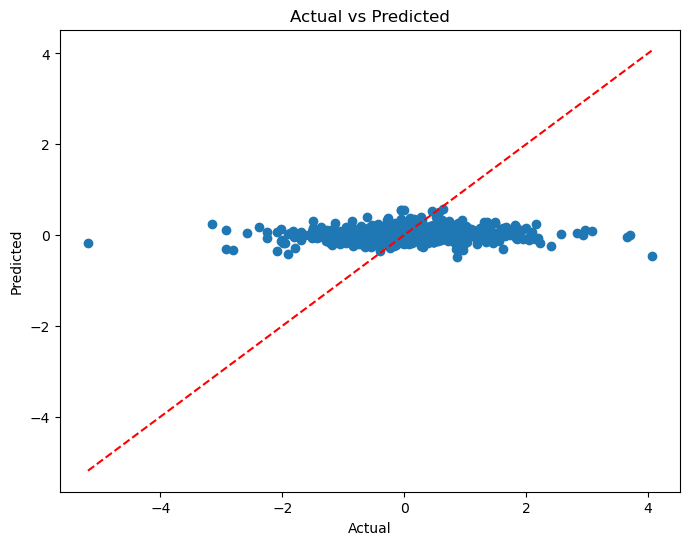

In [206]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [207]:

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")

[I 2024-06-01 18:11:22,617] A new study created in memory with name: no-name-907af1ce-c995-4ac2-bdd9-81ccb05f5b7a
[I 2024-06-01 18:11:28,837] Trial 0 finished with value: 0.6989086377217736 and parameters: {'n_estimators': 758, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6989086377217736.
[I 2024-06-01 18:11:38,692] Trial 1 finished with value: 0.6935368095196722 and parameters: {'n_estimators': 369, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 1 with value: 0.6935368095196722.
[I 2024-06-01 18:11:39,637] Trial 2 finished with value: 0.7830695559346726 and parameters: {'n_estimators': 268, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6935368095196722.
[I 2024-06-01 18:11:52,513] Trial 3 finished with value: 0.6886990428577843 and parameters: {'n_estimators': 388, 'max_depth': 19, 'min

Best Hyperparameters: {'n_estimators': 615, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}
Mean Absolute Error (MAE): 0.58
Root Mean Squared Error (RMSE): 0.80
Mean Squared Error(MSE): 0.65


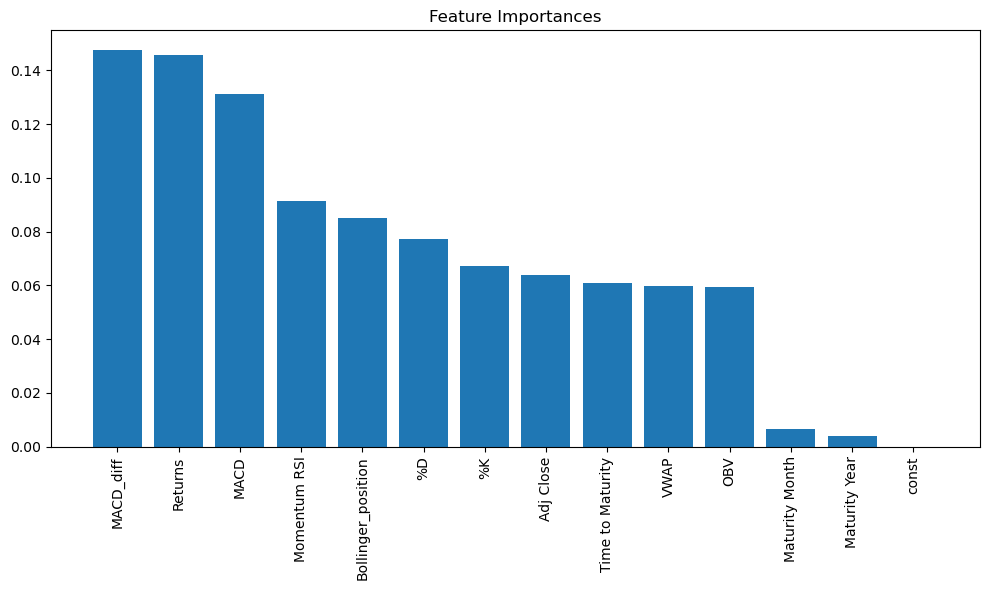

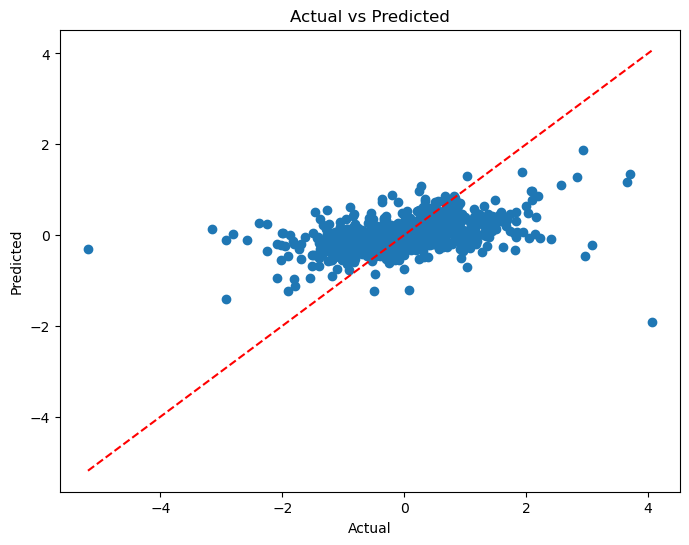

In [208]:
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()